# **Import các thư viện cần thiết**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import random

from PIL import Image
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

 # **Chuẩn bị dữ liệu**

In [2]:
def text_normalize(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip() 
    text = '<start> ' + text + ' <end>'
 
    return text

In [3]:
BATCH_SIZE = 32
MAX_SEQ_LEN = 30
IMG_SIZE = (128, 128)
VOCAB_SIZE = 5000 
AUTOTUNE = tf.data.AUTOTUNE

In [4]:
DATASET_ROOT_DIR = './space_image_captioning_dataset'
IMAGES_DIR_NAME = 'space_images'
CAPTIONS_FILENAME = 'space_captions.txt'

images_dir = os.path.join(
    DATASET_ROOT_DIR, 
    IMAGES_DIR_NAME
)

captions_filepath = os.path.join(
    DATASET_ROOT_DIR, 
    CAPTIONS_FILENAME
)

In [5]:
with open(captions_filepath, 'r', encoding='utf8') as f:
    lines = f.readlines()
    dataset_dict = {}
    skipped_images_lst = []
    corpus = []
    for line in lines:
        line = line.rstrip('\n')
        img_path, caption = line.split('\t')

        tokens = caption.split(' ')

        if len(tokens) < 5 or len(tokens) > (MAX_SEQ_LEN - 2):
            skipped_images_lst.append(img_path)
            continue
        else:
            normalized_caption = text_normalize(caption)
            corpus.append(normalized_caption)
            dataset_dict[img_path] = normalized_caption 

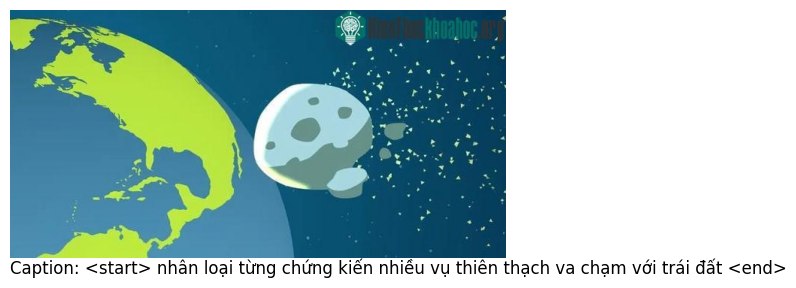

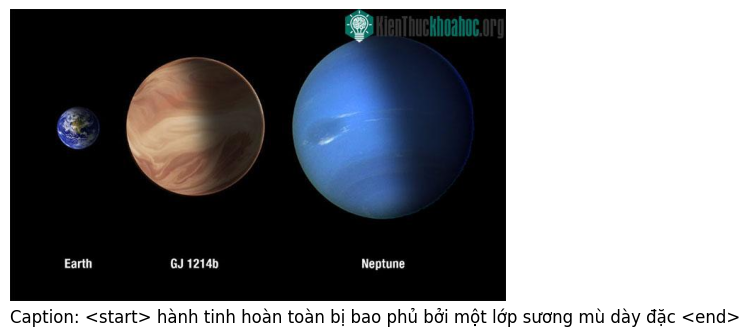

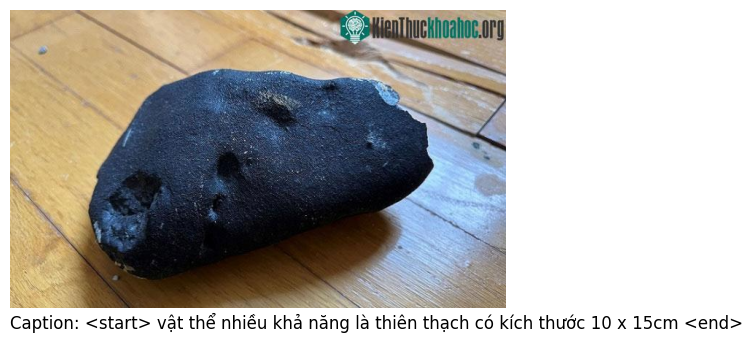

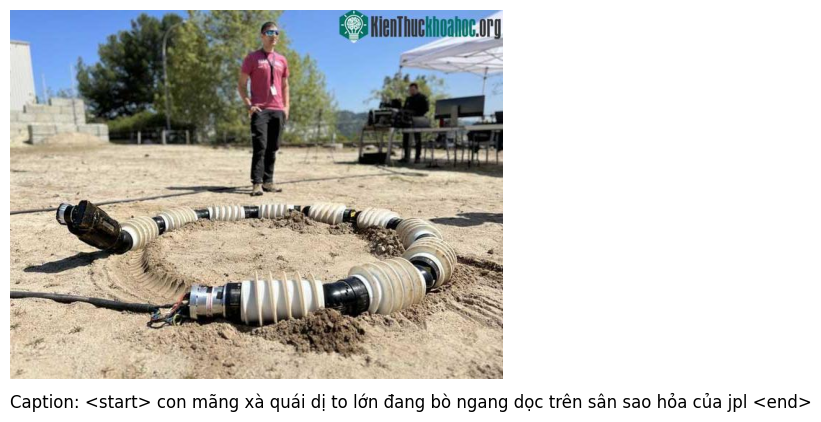

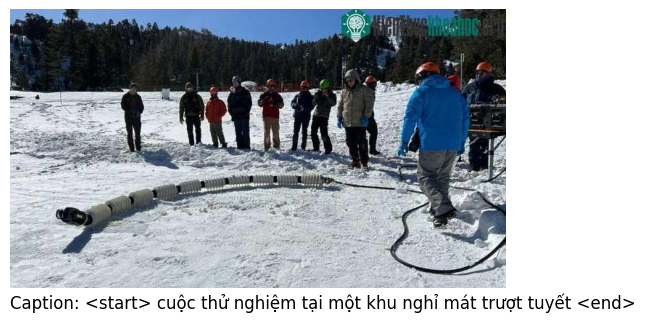

In [6]:
items_to_show = [
    (img_path, caption) 
    for idx, (img_path, caption) in \
        enumerate(dataset_dict.items()) if idx < 20
]

for idx in range(5):
    img_filename, caption = items_to_show[idx]
    img_path = os.path.join(images_dir, img_filename.split('/')[-1])
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f'Caption: {caption}', loc='left', y=-0.1)
    plt.axis('off')
    plt.show()

In [7]:
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_SEQ_LEN,
    standardize=None,
)
vectorizer.adapt(corpus)

VOCAB_SIZE = int(vectorizer.vocabulary_size())

img_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(0.3),
    ]
)

In [8]:
def preprocess_img(img_path):
    img = tf.io.read_file(img_path) 
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)

    return img

def process_input_data(img_path, caption, augment=False):
    img = preprocess_img(img_path)
    if augment == True:
        img = img_augmentation(img)
    cap = vectorizer(caption) 
    decoder_input = cap[:-1]
    decoder_output = cap[1:]

    return (img, decoder_input), decoder_output

In [9]:
X = np.array(list(dataset_dict.keys()))
y = np.array(list(dataset_dict.values()))

TRAIN_SIZE = 0.7
VAL_SIZE = 0.2
n_samples = len(X)
train_idx = int(n_samples * TRAIN_SIZE)
val_idx = train_idx + int(n_samples * VAL_SIZE)


idxs = np.arange(n_samples)
idxs = np.random.permutation(idxs)

X = X[idxs]
y = y[idxs]

X_train, y_train = X[:train_idx], y[:train_idx]
X_val, y_val = X[train_idx:val_idx], y[train_idx:val_idx] 
X_test, y_test = X[val_idx:], y[val_idx:]

In [10]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train, y_train)
)

val_ds = tf.data.Dataset.from_tensor_slices(
    (X_val, y_val)
)

test_ds = tf.data.Dataset.from_tensor_slices(
    (X_test, y_test)
)

train_ds = train_ds.cache().prefetch(
    buffer_size=AUTOTUNE
).map(
    lambda x, y: process_input_data(x, y, augment=True), 
    num_parallel_calls=AUTOTUNE
).batch(BATCH_SIZE)

val_ds = val_ds.cache().prefetch(
    buffer_size=AUTOTUNE
).map(
    process_input_data, 
    num_parallel_calls=AUTOTUNE
).batch(BATCH_SIZE)

test_ds = test_ds.cache().prefetch(
    buffer_size=AUTOTUNE
).map(
    process_input_data, 
    num_parallel_calls=AUTOTUNE
).batch(BATCH_SIZE)

# **Xây dựng mô hình**

Positional Encoding Layer

In [11]:
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

Self-attention Layer

In [12]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

Cross-attention Layer

In [13]:
class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True)

        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

Global Self-attention Layer

In [14]:
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        
        return x

Causal Self-attention Layer

In [15]:
class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            use_causal_mask = True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        
        return x

Feed-forward Network

In [16]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model),
        tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x

Encoder Layer

In [17]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

Transformer Encoder

In [18]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads,
                dff, vocab_size, dropout_rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(
            vocab_size=vocab_size, d_model=d_model)

        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                        num_heads=num_heads,
                        dff=dff,
                        dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.ffn = tf.keras.layers.Dense(d_model, activation='relu') 

    def call(self, x):
        x = self.layernorm(x)
        x = self.ffn(x)

        # Add dropout.
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.

Decoder Layer

In [19]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,
                *,
                d_model,
                num_heads,
                dff,
                dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)

        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.cross_attention.last_attn_scores

        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        return x

Transformer Decoder

In [20]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
                dropout_rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                                d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(d_model=d_model, num_heads=num_heads,
                        dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)]

        self.last_attn_scores = None

    def call(self, x, context):
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

        x = self.dropout(x)

        for i in range(self.num_layers):
            x  = self.dec_layers[i](x, context)

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        # The shape of x is (batch_size, target_seq_len, d_model).
        return x

CNN Model

In [21]:
def get_cnn_model():
    base_model = tf.keras.applications.vgg16.VGG16(
        input_shape=(*IMG_SIZE, 3), 
        include_top=False, 
        weights="imagenet"
    )
    
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = tf.keras.layers.Reshape(
        (-1, base_model_out.shape[-1])
    )(base_model_out)
    cnn_model = tf.keras.models.Model(
        base_model.input, 
        base_model_out
    )

    return cnn_model

Image Captioning Model

In [22]:
class ImageCaptioningModel(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff,
                vocab_size, dropout_rate=0.1):
        super().__init__()
        self.cnn_model = get_cnn_model()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                            num_heads=num_heads, dff=dff,
                            vocab_size=vocab_size,
                            dropout_rate=dropout_rate)

        self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                            num_heads=num_heads, dff=dff,
                            vocab_size=vocab_size,
                            dropout_rate=dropout_rate)

        self.final_layer = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        img, x  = inputs

        context = self.cnn_model(img)

        context = self.encoder(context)  # (batch_size, context_len, d_model)

        x = self.decoder(x, context)  # (batch_size, target_len, d_model)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass

        # Return the final output and the attention weights.
        return logits

In [23]:
N_LAYERS = 4
D_MODEL = 128
D_FF = 512
N_HEADS = 8
DROPOUT_RATE = 0.2

In [24]:
ic_model = ImageCaptioningModel(
    num_layers=N_LAYERS,
    d_model=D_MODEL,
    num_heads=N_HEADS,
    dff=D_FF,
    vocab_size=VOCAB_SIZE,
    dropout_rate=DROPOUT_RATE
)

In [25]:
for batch in val_ds.take(1):
    a, b = batch

In [26]:
out = ic_model.predict(a)

1/1 [==============================] - 8s 8s/step


In [27]:
out.shape

(32, 29, 2650)

In [28]:
ic_model.summary()

Model: "image_captioning_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 16, 512)           14714688  
                                                                 
 encoder (Encoder)           multiple                  2705536   
                                                                 
 decoder (Decoder)           multiple                  5089024   
                                                                 
 dense_17 (Dense)            multiple                  341850    
                                                                 
Total params: 22,851,098
Trainable params: 8,136,410
Non-trainable params: 14,714,688
_________________________________________________________________


# **Cấu hình mô hình**

In [29]:
# Khai báo một số giá trị siêu tham số
EPOCHS = 50

In [62]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [31]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, 
    beta_1=0.9, 
    beta_2=0.98,
    epsilon=1e-9
)

In [32]:
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)

    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [33]:
ic_model.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy]
)

# **Thực hiện huấn luyện**

In [34]:
history = ic_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)

Epoch 1/50
41/41 [==============================] - 148s 3s/step - loss: 7.8921 - masked_accuracy: 0.0018 - val_loss: 7.7783 - val_masked_accuracy: 0.0473
Epoch 2/50
41/41 [==============================] - 113s 3s/step - loss: 7.6686 - masked_accuracy: 0.0659 - val_loss: 7.5528 - val_masked_accuracy: 0.0682
Epoch 3/50
41/41 [==============================] - 122s 3s/step - loss: 7.4888 - masked_accuracy: 0.0689 - val_loss: 7.3990 - val_masked_accuracy: 0.0682
Epoch 4/50
41/41 [==============================] - 133s 3s/step - loss: 7.3120 - masked_accuracy: 0.0689 - val_loss: 7.2080 - val_masked_accuracy: 0.0682
Epoch 5/50
41/41 [==============================] - 151s 4s/step - loss: 7.0902 - masked_accuracy: 0.0689 - val_loss: 6.9797 - val_masked_accuracy: 0.0682
Epoch 6/50
41/41 [==============================] - 115s 3s/step - loss: 6.8440 - masked_accuracy: 0.0689 - val_loss: 6.7524 - val_masked_accuracy: 0.0689
Epoch 7/50
41/41 [==============================] - 118s 3s/step - los

# **Đánh giá và trực quan hóa**

In [38]:
# Đánh giá mô hình trên tập test
test_evaluation = ic_model.evaluate(test_ds)

6/6 [==============================] - 14s 2s/step - loss: 5.8854 - masked_accuracy: 0.2911


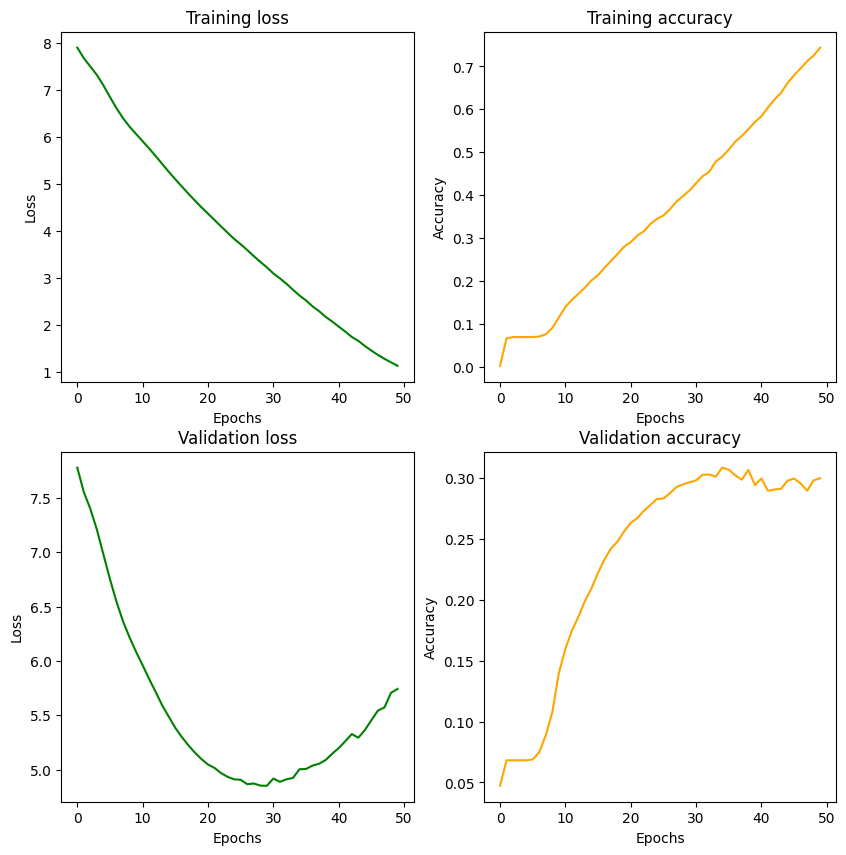

In [39]:
# Đọc các kết quả huấn luyện mô hình qua từng epoch
train_loss, train_acc = history.history['loss'], history.history['masked_accuracy'] # Đọc thông tin loss, acc trên tập train
val_loss, val_acc = history.history['val_loss'], history.history['val_masked_accuracy'] # Đọc thông tin loss, acc trên tập val

plt.figure(figsize=(10, 10)) # Cài đặt kích thước khung ảnh

plt.subplot(2, 2, 1) # Khởi tạo khung ảnh cho training loss
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Loss') # Hiển thị tên trục tung là 'Loss'
plt.title('Training loss') # Hiển thị title của khung ảnh hiện tại là 'Training Loss'
plt.plot(train_loss, color='green') # Vẽ đường giá trị loss trên tập train qua từng epoch (đường vẽ màu đỏ)

plt.subplot(2, 2, 2) # Khởi tạo khung ảnh cho training acc
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Accuracy') # Hiển thị tên trục tung là 'Accuracy'
plt.title('Training accuracy') # Hiển thị title của khung ảnh hiện tại là 'Training accuracy'
plt.plot(train_acc, color='orange') # Vẽ đường giá trị accuracy trên tập train qua từng epoch (đường vẽ màu cam)

plt.subplot(2, 2, 3) # Khởi tạo khung ảnh cho val loss
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Loss') # Hiển thị tên trục tung là 'Loss'
plt.title('Validation loss') # Hiển thị title của khung ảnh hiện tại là 'Validation loss'
plt.plot(val_loss, color='green') # Vẽ đường giá trị loss trên tập val qua từng epoch (đường vẽ màu đỏ)

plt.subplot(2, 2, 4) # Khởi tạo khung ảnh cho val acc
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Accuracy') # Hiển thị tên trục tung là 'Accuracy'
plt.title('Validation accuracy') # Hiển thị title của khung ảnh hiện tại là 'Validation accuracy'
plt.plot(val_acc, color='orange') # Vẽ đường giá trị accuracy trên tập val qua từng epoch (đường vẽ màu cam)

plt.show() # Hiển thị 4 khung ảnh nhỏ

In [40]:
vocab = vectorizer.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))

In [41]:
def compute_perplexity(logits, targets):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

    loss = loss_fn(targets, logits)

    perplexity = np.exp(np.mean(loss))

    return perplexity


def compute_bleu(predicted, targets):
    predicted_strings = []
    for seq in predicted:
        seq = np.argmax(seq, axis=1)
        string_seq = " ".join([index_lookup[token] for token in seq if token != 0])
        predicted_strings.append(string_seq)
    target_strings = []
    for seq in targets:
        seq = seq.numpy().tolist()
        string_seq = " ".join([index_lookup[token] for token in seq if token != 0])
        target_strings.append([string_seq])  

    bleu_score = corpus_bleu(target_strings, predicted_strings)

    return bleu_score

perplexities = []
bleu_scores = []

for sample in test_ds.take(10):
    X_try, y_try = sample
    y_pred = ic_model(X_try)

    batch_perplexity = compute_perplexity(y_pred, y_try)
    batch_bleu_score = compute_bleu(y_pred, y_try)

    perplexities.append(batch_perplexity)
    bleu_scores.append(batch_bleu_score)

    # print(f'Perplexity: {batch_perplexity}')
    # print(f'BLEU score: {batch_bleu_score}')

print(f'Perplexity: {sum(perplexities) / len(perplexities)}')
print(f'BLEU score: {sum(bleu_scores) / len(bleu_scores)}')

Perplexity: 1590691.5416666667
BLEU score: 0.1783100084812427


# **Inference**

In [42]:
def generate_caption(
    img_path,
    ic_model,
    vectorizer
):
    img = preprocess_img(img_path)
    display_img = img.numpy().clip(0, 255).astype(np.uint8)
    
    img = np.expand_dims(display_img, axis=0)
    output_str = '<start>'

    for idx in range(MAX_SEQ_LEN):
        tokenized_caption = vectorizer([output_str])[:, :-1]
        pred = ic_model.predict((img, tokenized_caption), verbose=0)
        sampled_token_idx = np.argmax(pred[0, idx, :])
        sampled_token = index_lookup[sampled_token_idx]
        if sampled_token == '<end>':
            break 
        output_str += f' {sampled_token}'
    
    generated_caption = output_str.replace('<start>', '')
    generated_caption = generated_caption.replace('<end>', '')
    generated_caption = generated_caption.strip()

    return display_img, generated_caption

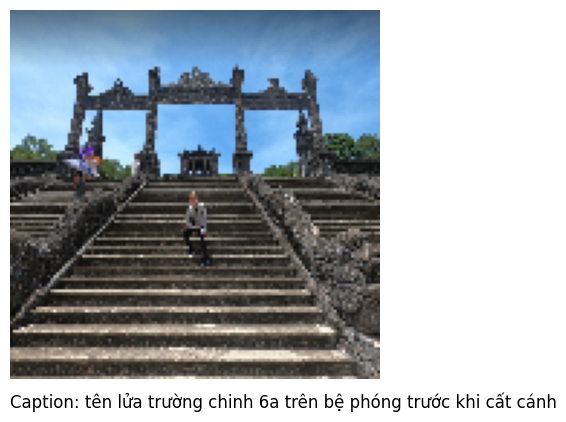

In [58]:
# input_img_path = 'space_image_captioning_dataset\space_images\IMG_000003.jpg'
input_img_path = "Screenshot_3.png"
display_img, generated_caption = generate_caption(
    input_img_path,
    ic_model,
    vectorizer
)

plt.imshow(display_img)
plt.title(f'Caption: {generated_caption}', loc='left', y=-0.1)
plt.axis('off')
plt.show()